Step 4: Optimization with uncertain conversion rates, 𝛼 ratios, and number of items sold per product

In [1]:
#fixed graph weights (same click influence probabilities between the products for each user)
#homogeneous users (one class with small variability)
#uncertain alphas
#uncertain number of items sold per product
#uncertain conversion rates

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from Environment.E_commerce import *
from Environment.Product import *
from Algorithms.Conv_rates_Learner import *
from Algorithms.TS_Learner_poisson import *
from Algorithms.Learner_Environment import *
from Algorithms.UCB_Learner import *
from Algorithms.Greedy_Learner import *

In [2]:
P1 = Product(0,[19.99, 21.99, 23.99, 26.99],np.multiply([0.2, 0.2, 0.2, 0.2],[19.99, 19.99, 19.99, 19.99])+[0, 21.99-19.99, 23.99-19.99, 26.99-19.99])
# t-shirt
P2 = Product(1,[29.99, 32.59, 35.99, 39.99],np.multiply([0.2, 0.2, 0.2, 0.2],[29.99, 29.99, 29.99, 29.99])+[29.99, 32.59, 35.99, 39.99]-29.99)
# shirt
P3 = Product(2,[25.99,28.99, 31.99, 34.99],np.multiply([0.3, 0.3, 0.3, 0.3],[25.99,25.99, 25.99, 25.99])+[25.99,28.99, 31.99, 34.99]-25.99)
# shorts
P4 = Product(3,[38.99,43.99,46.99, 49.99],np.multiply([0.4, 0.4, 0.4, 0.4],[38.99,38.99,38.99, 38.99])+[38.99,43.99,46.99, 49.99]-38.99)
# pants
P5 = Product(4,[79.99,89.99, 99.99, 109.99],np.multiply([0.5, 0.5, 0.5, 0.5],[79.99,79.99, 79.99, 79.99])+[79.99,89.99, 99.99, 109.99]-79.99)
# shoes

products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
expected_units_sold_per_product = np.array([2,1,3,3,1]) #these are the lambdas defined in the visit function
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
E = E_commerce()
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0., 1. , 0.5 , 0. ],[0. , 0. , 0.5 , 1., 0. ],[0.5 , 1. , 0. , 0. , 0. ],[1. , 0.5 , 0. , 0. , 0. ],[0. , 0.5 , 0. , 1. , 0. ]])

In [3]:
#Random algorithm which for each round pulls a random choice 
#to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
#useful for computing clairvoyant solution and regrets of the bandit algorithms


n_arms = 4
num_users = 100
n_days = 1000
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 10
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_eperiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm()
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_eperiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given chosing each round the best combination
opt = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = np.zeros(5)
for i in range(5):   
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i] 
                                        * np.mean(mean_units_sold_per_product_per_eperiment, axis = 0)[i])#expected_units_sold_per_product[i])#
    
print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected rewards per arm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_eperiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt) # optimal configuration: the best combination of arms


_______________________________________________
Conversion rates
[[0.8948889  0.53650252 0.13857589 0.00175789]
 [0.91224914 0.63089564 0.12499652 0.00124504]
 [0.95748422 0.64784031 0.15865632 0.00504293]
 [0.97140524 0.66926895 0.29898714 0.05281353]
 [0.99771992 0.7713081  0.47617634 0.02782343]]
_______________________________________________
Expected rewards per arm
[[ 7.04144513  6.41651048  2.31744956  0.03949878]
 [ 5.48809465  5.47932052  1.5339767   0.0162839 ]
 [21.1356132  19.7884315   6.21573614  0.24812082]
 [45.21966014 41.49841513 21.44411382  4.29238599]
 [37.99169404 36.24032883 27.65172511  2.02342625]]
_______________________________________________
Expected units sold per arm
[[1.99413442 1.98110915 2.01513027 1.82704977]
 [1.         1.         1.         1.        ]
 [3.02326226 3.03035841 2.96592185 2.86510124]
 [2.99794033 3.00007925 3.01608105 3.03459809]
 [1.         1.         1.         1.        ]]
_______________________________________________
Best confi

In [4]:
mean_units_sold_per_product_per_eperiment

[array([[2.00926828, 1.94714413, 1.9364207 , 1.04786518],
        [1.        , 1.        , 1.        , 1.        ],
        [2.97985143, 3.06299264, 2.93081076, 3.00964828],
        [2.98127095, 2.98789188, 2.99883531, 2.96139252],
        [1.        , 1.        , 1.        , 1.        ]]),
 array([[2.01242186, 1.97650475, 1.99442615, 1.96101959],
        [1.        , 1.        , 1.        , 1.        ],
        [2.9810732 , 3.01663756, 2.94196788, 2.99487717],
        [3.00332258, 2.97892585, 3.04689047, 3.03444667],
        [1.        , 1.        , 1.        , 1.        ]]),
 array([[2.01635004, 1.99030803, 2.00532946, 2.0482516 ],
        [1.        , 1.        , 1.        , 1.        ],
        [3.01055218, 3.03232923, 2.89099189, 4.76571183],
        [3.01735267, 2.98738337, 2.95426472, 3.04389957],
        [1.        , 1.        , 1.        , 1.        ]]),
 array([[1.99113202, 1.93472642, 2.01496843, 2.05758882],
        [1.        , 1.        , 1.        , 1.        ],
        

In [6]:
#Comparison between TS and UCB

n_arms = 4
num_users = 100
n_days = 300
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ts_rewards_per_experiment = []
ucb_rewards_per_experiment = []
gr_rewards_per_experiment = []
cr_rewards_per_experiment = []

ts_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []

ts_rewards_per_day = np.zeros(n_days)
ucb_rewards_per_day = np.zeros(n_days)

for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    gr_learner = Greedy(n_arms=n_arms)
    ucb_learner = UCB(n_arms=n_arms)
    ts_learner = TS_poisson(n_arms=n_arms)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)

        pulled_arm = gr_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        gr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day)  

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)
        ucb_rewards_per_day[d] += np.sum(reward)
        
        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)
        ts_rewards_per_day[d] += np.sum(reward)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)
    gr_rewards_per_experiment.append(gr_learner.collected_rewards)
    cr_rewards_per_experiment.append(cr_learner.collected_rewards)

    ts_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

ts_rewards_per_day = ts_rewards_per_day/n_experiments
ucb_rewards_per_day = ucb_rewards_per_day/n_experiments

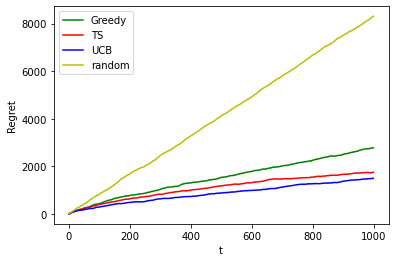

In [7]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - gr_rewards_per_experiment, axis=0)), 'g')
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.plot(np.cumsum(np.mean(opt - cr_rewards_per_experiment, axis=0)), 'y')
plt.legend(["Greedy","TS","UCB","random"])
plt.show()

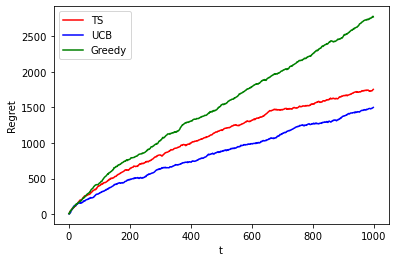

In [8]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.plot(np.cumsum(np.mean(opt - gr_rewards_per_experiment, axis=0)), 'g')
plt.legend(["TS","UCB","Greedy"])
plt.show()

In [9]:
print("_______________________________________________")
print("TS Total collected reward")
print(np.sum(np.mean(ts_rewards_per_experiment,axis=0)))
print("UCB Total collected reward")
print(np.sum(np.mean(ucb_rewards_per_experiment,axis=0)))
print("_______________________________________________")

print("Considering all the experiments:")
print("-----------------------------------------------")
print("Total expected reward over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print("TS",np.mean(np.sum(ts_rewards_per_experiment, axis=1)),np.std(np.sum(ts_rewards_per_experiment, axis = 1)))
print("UCB",np.mean(np.sum(ucb_rewards_per_experiment, axis=1)),np.std(np.sum(ucb_rewards_per_experiment, axis = 1)))
print("-----------------------------------------------")
print("Total expected regret over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print("TS",np.mean(np.sum(opt - ts_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ts_rewards_per_experiment, axis=1)))
print("UCB",np.mean(np.sum(opt - ucb_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ucb_rewards_per_experiment, axis=1)))

print("-----------------------------------------------")
print("Average expected reward per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print("TS",np.mean(np.mean(ts_rewards_per_experiment, axis=0)), np.std(np.mean(ts_rewards_per_experiment, axis=0)))
print("UCB",np.mean(np.mean(ucb_rewards_per_experiment, axis=0)), np.std(np.mean(ucb_rewards_per_experiment, axis=0)))
print("-----------------------------------------------")
print("Average expected regret per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print("TS",np.mean(np.mean(opt-ts_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ts_rewards_per_experiment, axis=0)))
print("UCB",np.mean(np.mean(opt-ucb_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ucb_rewards_per_experiment, axis=0)))

_______________________________________________
TS Total collected reward
47238.07200937951
UCB Total collected reward
47491.82153138528
_______________________________________________
Considering all the experiments:
-----------------------------------------------
Total expected reward over 1000 days and its standard deviation considering 10 experiments
TS 47238.07200937951 826.054348203146
UCB 47491.821531385285 564.8743380720076
-----------------------------------------------
Total expected regret over 1000 days and its standard deviation considering 10 experiments
TS 1754.6259873896295 826.0543482031461
UCB 1500.8764653838573 564.8743380720067
-----------------------------------------------
Average expected reward per round over 1000 days and its standard deviation between the rounds considering 10 experiments
TS 47.23807200937951 3.351133726908961
UCB 47.49182153138528 3.342032906479586
-----------------------------------------------
Average expected regret per round over 1000 day

In [10]:
print("TS Pulls per arm")
for i in range(len(ts_pulls_per_arm_per_experiment)):
    print("_______________________________________________")
    print(ts_pulls_per_arm_per_experiment[i])

TS Pulls per arm
_______________________________________________
[[  1. 793.   1. 205.]
 [ 66. 749. 147.  38.]
 [965.   3.   1.  31.]
 [  2. 969.  28.   1.]
 [880. 103.   8.   9.]]
_______________________________________________
[[  1. 110. 810.  79.]
 [  5. 673. 227.  95.]
 [705.  74. 215.   6.]
 [925.  38.  36.   1.]
 [682. 295.   9.  14.]]
_______________________________________________
[[  1.  95. 903.   1.]
 [ 27. 706. 222.  45.]
 [919.   1.   3.  77.]
 [  3. 935.  51.  11.]
 [846. 110.  20.  24.]]
_______________________________________________
[[  1.   5. 729. 265.]
 [ 14. 717. 226.  43.]
 [  4. 918.  68.  10.]
 [969.   1.  29.   1.]
 [866. 124.   9.   1.]]
_______________________________________________
[[  1.  88. 852.  59.]
 [ 22. 309. 621.  48.]
 [  4. 960.  35.   1.]
 [939.  42.  12.   7.]
 [904.  36.  51.   9.]]
_______________________________________________
[[  1.  51. 765. 183.]
 [ 25. 853.  64.  58.]
 [776. 133.  76.  15.]
 [709. 267.   4.  20.]
 [773. 199.  18.  10.]]

In [11]:
print("UCB Pulls per arm")
for i in range(len(ucb_pulls_per_arm_per_experiment)):
    print("_______________________________________________")
    print(ucb_pulls_per_arm_per_experiment[i])

UCB Pulls per arm
_______________________________________________
[[ 11. 277. 256. 456.]
 [ 21.   2. 956.  21.]
 [374. 567.  57.   2.]
 [  2. 734. 262.   2.]
 [843. 138.  17.   2.]]
_______________________________________________
[[  2. 190. 775.  33.]
 [ 28.   2. 958.  12.]
 [699. 256.  43.   2.]
 [967.  27.   4.   2.]
 [966.  26.   6.   2.]]
_______________________________________________
[[  2. 832.   4. 162.]
 [  8. 988.   2.   2.]
 [  2. 993.   3.   2.]
 [972.  24.   2.   2.]
 [961.  35.   2.   2.]]
_______________________________________________
[[  2. 269. 566. 163.]
 [118. 864.  15.   3.]
 [449. 504.  45.   2.]
 [979.  15.   4.   2.]
 [988.   8.   2.   2.]]
_______________________________________________
[[  2. 204. 654. 140.]
 [  2.  41. 949.   8.]
 [  5. 978.  10.   7.]
 [942.  45.   6.   7.]
 [994.   2.   2.   2.]]
_______________________________________________
[[  2. 318. 363. 317.]
 [ 84. 795. 101.  20.]
 [416. 511.  63.  10.]
 [882.  97.  19.   2.]
 [  2. 988.   2.   8.]

In [12]:
# Not always find the best solution
#[994.   2.   2.   2.]
#[186. 778.  34.   2.]
#[  2.   2. 981.  15.] ------ doesn't found the optimal price (1)
#[994.   2.   2.   2.]
#[282. 713.   3.   2.]]
# Happens also with TS

In [ ]:
#Theoretical bounds for TS
KL = np.zeros(n_days)
for i in range(n_days):
    KL[i] = opt * np.log(opt / ts_rewards_per_day[i])
delta_ts = opt - ts_rewards_per_day
UPPER_bound_regret_ts = (1 + 10) * np.log(ts_learner.t) + np.log(np.log(ts_learner.t)) * np.sum(delta_ts / KL)
empiric_regret_ts = np.sum(opt - ts_rewards_per_day)
print("_______________________________________________")
print("Upper bound for the TS regret")
print(UPPER_bound_regret_ts)
# ratio empiric_regret/upper_bound
print("_______________________________________________")
print("Ratio between empirical regret and upper bound for the regret")
print(empiric_regret_ts / UPPER_bound_regret_ts)

In [ ]:
#Theoretical bounds for UCB
delta_ucb = opt - ucb_rewards_per_day
UPPER_bound_regret_ucb = 4*np.log(ucb_learner.t)*np.sum(1/delta_ucb+8*delta_ucb)
empiric_regret_ucb = np.sum(opt-ucb_rewards_per_day)
print("_______________________________________________")
print("Upper bound for the UCB regret")
print(UPPER_bound_regret_ucb)
# ratio empiric_regret/upper_bound
print("_______________________________________________")
print("Ratio between empirical regret and upper bound for the regret")
print( empiric_regret_ucb/UPPER_bound_regret_ucb)

In [13]:
#Comparison between TS and UCB with respect to the number of users per round

n_arms = 4
num_users = 10
n_days = 1000
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ts_rewards_per_experiment_10 = []
ucb_rewards_per_experiment_10 = []

ts_rewards_per_experiment_100 = []
ucb_rewards_per_experiment_100 = []


ts_rewards_per_experiment_1000 = []
ucb_rewards_per_experiment_1000 = []


for e in range(n_experiments):

    env_10 = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner_10 = UCB(n_arms=n_arms)
    ts_learner_10 = TS_poisson(n_arms=n_arms)

    env_100 = Environment(n_arms, E, margins_matrix, num_users*10, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner_100 = UCB(n_arms=n_arms)
    ts_learner_100 = TS_poisson(n_arms=n_arms)

    env_1000 = Environment(n_arms, E, margins_matrix, num_users*100, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner_1000 = UCB(n_arms=n_arms)
    ts_learner_1000 = TS_poisson(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = ucb_learner_10.pull_arm()
        reward = env_10.round(pulled_arm)
        ucb_learner_10.update(pulled_arm, reward)

        pulled_arm = ucb_learner_100.pull_arm()
        reward = env_100.round(pulled_arm)
        ucb_learner_100.update(pulled_arm, reward)

        pulled_arm = ucb_learner_1000.pull_arm()
        reward = env_1000.round(pulled_arm)
        ucb_learner_1000.update(pulled_arm, reward)
        
        pulled_arm = ts_learner_10.pull_arm(env_10.margins_matrix)
        reward = env_10.round(pulled_arm)
        ts_learner_10.update(pulled_arm, reward, env_10.clicks_current_day, env_10.purchases_current_day, env_10.daily_units)

        pulled_arm = ts_learner_100.pull_arm(env_100.margins_matrix)
        reward = env_100.round(pulled_arm)
        ts_learner_100.update(pulled_arm, reward, env_100.clicks_current_day, env_100.purchases_current_day,  env_100.daily_units)

        pulled_arm = ts_learner_1000.pull_arm(env_1000.margins_matrix)
        reward = env_1000.round(pulled_arm)
        ts_learner_1000.update(pulled_arm, reward, env_1000.clicks_current_day, env_1000.purchases_current_day,  env_1000.daily_units)

    ts_rewards_per_experiment_10.append(ts_learner_10.collected_rewards)
    ucb_rewards_per_experiment_10.append(ucb_learner_10.collected_rewards)

    
    ts_rewards_per_experiment_100.append(ts_learner_100.collected_rewards)
    ucb_rewards_per_experiment_100.append(ucb_learner_100.collected_rewards)

    
    ts_rewards_per_experiment_1000.append(ts_learner_1000.collected_rewards)
    ucb_rewards_per_experiment_1000.append(ucb_learner_1000.collected_rewards)


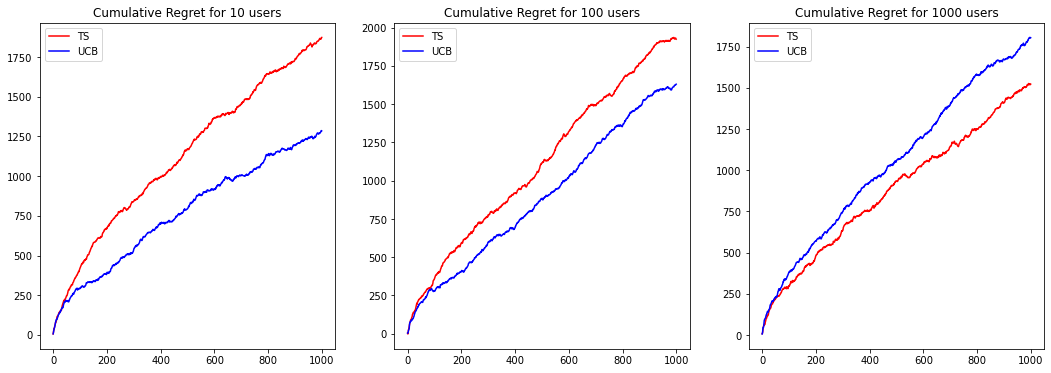

In [14]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18,6))
ax[0].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_10, axis=0)), 'r')
ax[0].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_10, axis=0)), 'b')
ax[0].set_title("Cumulative Regret for 10 users")
ax[0].legend(["TS","UCB"])

ax[1].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_100, axis=0)), 'r')
ax[1].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_100, axis=0)), 'b')
ax[1].set_title("Cumulative Regret for 100 users")
ax[1].legend(["TS","UCB"])

ax[2].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_1000, axis=0)), 'r')
ax[2].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_1000, axis=0)), 'b')
ax[2].set_title("Cumulative Regret for 1000 users")
ax[2].legend(["TS","UCB"])

plt.show()